# Introduction

This notebook examines a compendium of tweets collected from users on Twitter, with labels 0 and 1, denoting 
Negative and Positive respectively. As part of an NLP project on Sentiment Analysis, several models are fitted to the dataset in an attempt to find the model that can best classify tweets as either Negative or Positive.

## Variables
There are only 2 variables:

- Label: Sentiment (1 = Positive, 0 = Negative)
- Text: Contents of tweet 

## Structure
The notebook is structured as follows:
1. Data preprocessing
2. Exploratory data analysis
3. Fitting of models to data
4. Evaluation of models

### Importing Libraries

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

# Natural Language Processing
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from wordcloud import WordCloud, STOPWORDS

# Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, GlobalMaxPool1D, Conv1D, \
Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
!pip install keras_tuner
import keras_tuner

# General use
import string
!pip install contractions
import contractions
from collections import defaultdict
from copy import deepcopy
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 15.9 MB/s eta 0:00:00
Mounted at /content/drive


In [8]:
## nltk package installation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Reading Dataset

In [9]:
df = pd.read_csv('drive/MyDrive/IT1244_Team13_Project/Dataset/dataset.csv', header = None) # load csv file as pandas dataframe
df.columns = ['label', 'text'] # rename columns as `label` and `text`

In [10]:
df.head(5)

label                                               text
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all....

In [11]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 100000
Number of columns: 2


In [12]:
df.label.value_counts() # count number of values under `label`

0    50000
1    50000
Name: label, dtype: int64

We have 100,000 rows in our dataset, of which 50,000 are labelled `0` and 50,000 are labelled `1`.

### Data Preprocessing

In [13]:
"""
References: 
https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
"""

### Helper functions
def remove_tags(text): # Removing tags, e.g. @someone_somewhere
    tags = re.compile(r'\@[A-Za-z0-9_]*')
    return tags.sub(r'', text)

def remove_urls(text): # Removing links, e.g. www.google.com. 
    urls = re.compile(r'([\w+]+\:\/\/)?([\w\d-]+\.)*[\w-]+[\.\:]\w+([\/\?\=\&\#\.]?[\w-]+)*\/?')
    return urls.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_puncts(text): # Removing punctuations, e.g. ',' or '!'
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_html(text): # Removing html, e.g. <div> or <a href="...">
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_contractions(text): # Removing contractions, e.g. "She'd" becomes "She would"
    return contractions.fix(text)

In [14]:
# Cleaning data
df['text'] = df['text'].apply(lambda x: remove_tags(x))
df['text'] = df['text'].apply(lambda x: remove_urls(x))
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text'] = df['text'].apply(lambda x: remove_puncts(x))
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text'] = df['text'].apply(lambda x: remove_contractions(x))
df['text'] = df['text'].apply(lambda x: x.strip())
df['text'] = df['text'].apply(lambda x: x.lower())

In [15]:
### Reference: https://www.kaggle.com/rftexas/text-only-kfold-bert
abbrev = {
    'afaik': 'as far as i know',
    'afk': 'away from keyboard',
    'btw': 'by the way',
    'b4': 'before',
    'bae': 'babe',
    'brb': 'be right back',
    'bro': 'brother',
    'bros': 'brothers',
    'cia': 'central intelligence agency',
    'cya': 'see you',
    'dae': 'does anyone else',
    'diy': 'do it yourself',
    'dm': 'direct message',
    'eg': 'for example',
    'etc': 'and so on',
    'faq': 'frequently asked questions',
    'fb': 'facebook',
    'fig': 'figure',
    'ft': 'featuring',
    'ftw': 'for the win',
    'ftl': 'for the loss',
    'fwiw': 'for what it is worth',
    'fyi': 'for your information',
    'gg': 'good game',
    'gl': 'good luck',
    'glhf': 'good luck have fun',
    'goat': 'greatest of all time',
    'gn': 'good night',
    'gr8': 'great',
    'gratz': 'congratulations',
    'ic': 'i see',
    'idc': 'i do not care',
    'idgaf': 'i do not give a fuck',
    'iirc': 'if i remember correctly',
    'ily': 'i love you',
    'imo': 'in my opinion',
    'imho': 'in my honest opinion',
    'irl': 'in real life',
    'jic': 'just in case',
    'jk': 'just kidding',
    'ldr': 'long distance relationship',
    'lol': 'laugh out loud',
    'lmao': 'laugh my ass off',
    'lmfao': 'laugh my fucking ass off',
    'm8': 'mate',
    'mf': 'motherfucker',
    'mofo': 'motherfucker',
    'mfw': 'my face when',
    'ngl': 'not going to lie',
    'nsfl': 'not safe for life',
    'nsfw': 'not safe for work',
    'nvr': 'never',
    'nv': 'never',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pov': 'point of view',
    'rt': 'retweet',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shake my head',
    'srsly': 'seriously',
    'tbh': 'to be honest',
    'thks': 'thanks',
    'ty': 'thank you',
    'til': 'today i learnt',
    'tldr': 'too long i did not read',
    'tl;dr': 'too long i did not read',
    'ttyl': 'talk to you later',
    'u': 'you',
    'w8': 'wait',
    'wassup': 'what is up',
    'wtf': 'what the fuck',
    'wth': 'what the hell'
}

In [16]:
### Reference: https://www.kaggle.com/rftexas/text-only-kfold-bert

### Helper functions
def convert_abbrev_word(word): # convert all abbreviated words to lower case
    return abbrev[word.lower()] if word.lower() in abbrev.keys() else word

def convert_abbrev(text): # unabbreviate text
    tokens = word_tokenize(text)
    converted = [convert_abbrev_word(word) for word in tokens]
    converted = ' '.join(converted)
    return converted

In [17]:
# Convert abbreviations
df['text'] = df['text'].apply(lambda x: convert_abbrev(x)) 

In [18]:
# Tokenizing text
df['tokenized'] = df['text'].apply(word_tokenize) 

In [19]:
# Removing stop words i.e. unimportant words such as 'is' and 'and'
stop = set(stopwords.words('english'))
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop])

Reference: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python for inspiration on Part of Speech Tagging, Wordnet and Lemmatization.

In [20]:
# Part of Speech Tagging - labelling words with their grammatical function, e.g. noun or verb
df['pos_tagged'] = df['stopwords_removed'].apply(pos_tag)

In [21]:
def get_wordnet_pos(tag): # convert part of speech tags to wordnet format
    if tag.startswith('J'):
        return wordnet.ADJ
    
    elif tag.startswith('V'):
        return wordnet.VERB
    
    elif tag.startswith('N'):
        return wordnet.NOUN
    
    elif tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN
    
df['wordnet'] = df['pos_tagged'].apply(lambda x: [(word, get_wordnet_pos(tag)) for (word, tag) in x])

In [22]:
# Converting inflected words to meaningful base form, e.g. rocks -> rock or better -> good
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['wordnet'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])

In [23]:
# Combining lemmatized text into a single string
df['text_lemmatized'] = [' '.join(map(str, word)) for word in df['lemmatized']]

### Exploratory Data Analysis

Here, we will explore:
- Length of tweets (characters)
- Length of tweets (words)
- N-grams

In [24]:
df['text_len'] = df['text'].apply(len) # get length of text
df['text_lemm_len'] = df['text_lemmatized'].apply(len) # get length of lemmatized text

In [25]:
# Plotting histogram of message length grouped by label
fig = go.Figure()
fig.add_trace(go.Histogram(x = df[df['label'] == 0].text_len, name = 'Label 0', opacity = 0.7, marker_color = '#EB89B5'))
fig.add_trace(go.Histogram(x = df[df['label'] == 1].text_len, name = 'Label 1', opacity = 0.7, marker_color = '#330C73'))

fig.update_layout(barmode = 'stack', title_text = 'Histogram of Message Length', xaxis_title_text = 'Length of Message', 
                 yaxis_title_text = 'Count', bargap = 0.2, bargroupgap = 0.05)
fig.show()

In [26]:
# Plotting histogram of lemmatized message length grouped by label
fig = go.Figure()
fig.add_trace(go.Histogram(x = df[df['label'] == 0].text_lemm_len, name = 'Label 0', opacity = 0.7, marker_color = '#EB89B5'))
fig.add_trace(go.Histogram(x = df[df['label'] == 1].text_lemm_len, name = 'Label 1', opacity = 0.7, marker_color = '#330C73'))

fig.update_layout(barmode = 'stack', title_text = 'Histogram of Message Length (LEMMATIZED)', xaxis_title_text = 'Length of Message (LEMMATIZED)', 
                 yaxis_title_text = 'Count', bargap = 0.2, bargroupgap = 0.05)
fig.show()

In [27]:
df[df['label'] == 0]['text_len'].describe()

count    50000.000000
mean        65.543840
std         35.272016
min          0.000000
25%         36.000000
50%         61.000000
75%         94.000000
max        161.000000
Name: text_len, dtype: float64

In [28]:
df[df['label'] == 1]['text_len'].describe()

count    50000.000000
mean        62.101300
std         34.399717
min          0.000000
25%         34.000000
50%         57.000000
75%         89.000000
max        189.000000
Name: text_len, dtype: float64

In [29]:
df[df['label'] == 0]['text_lemm_len'].describe()

count    50000.000000
mean        40.293040
std         22.884942
min          0.000000
25%         22.000000
50%         37.000000
75%         57.000000
max        142.000000
Name: text_lemm_len, dtype: float64

In [30]:
df[df['label'] == 1]['text_lemm_len'].describe()

count    50000.000000
mean        39.489420
std         22.717823
min          0.000000
25%         21.000000
50%         36.000000
75%         55.000000
max        127.000000
Name: text_lemm_len, dtype: float64

It seems that messages labelled 0 or 1 have very similar mean lengths (both lemmatized and not) as well as standard deviations in text length, which implies that the message lengths do not have much explanatory power in differentiating between the two classes.

Let us consider the number of words as well.

In [31]:
df['num_words'] = df['text'].apply(lambda text: len(text.split())) # getting number of words in text
df['num_words_lemm'] = df['text_lemmatized'].apply(lambda text: len(text.split())) # getting number of words in lemmatized text

In [32]:
# Plotting histogram of number of words per message
fig = go.Figure()
fig.add_trace(go.Histogram(x = df[df['label'] == 0].num_words, name = 'Label 0', opacity = 0.7, marker_color = '#EB89B5'))
fig.add_trace(go.Histogram(x = df[df['label'] == 1].num_words, name = 'Label 1', opacity = 0.7, marker_color = '#330C73'))

fig.update_layout(barmode = 'stack', title_text = 'Histogram of Number of Words per Message', xaxis_title_text = 'Number of Words per Message', 
                 yaxis_title_text = 'Count', bargap = 0.2, bargroupgap = 0.05)
fig.show()

In [33]:
# Plotting histogram of number of words per lemmatized message
fig = go.Figure()
fig.add_trace(go.Histogram(x = df[df['label'] == 0].num_words_lemm, name = 'Label 0', opacity = 0.7, marker_color = '#EB89B5'))
fig.add_trace(go.Histogram(x = df[df['label'] == 1].num_words_lemm, name = 'Label 1', opacity = 0.7, marker_color = '#330C73'))

fig.update_layout(barmode = 'stack', title_text = 'Histogram of Number of Words per Message (LEMMATIZED)', xaxis_title_text = 'Number of Words per Message (LEMMATIZED)', 
                 yaxis_title_text = 'Count', bargap = 0.2, bargroupgap = 0.05)
fig.show()

In [34]:
df[df['label'] == 0]['num_words'].describe()

count    50000.000000
mean        13.457500
std          7.255092
min          0.000000
25%          7.000000
50%         13.000000
75%         19.000000
max         40.000000
Name: num_words, dtype: float64

In [35]:
df[df['label'] == 1]['num_words'].describe()

count    50000.000000
mean        12.413720
std          6.981548
min          0.000000
25%          7.000000
50%         11.000000
75%         18.000000
max         39.000000
Name: num_words, dtype: float64

In [36]:
df[df['label'] == 0]['num_words_lemm'].describe()

count    50000.000000
mean         7.021440
std          3.864453
min          0.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         28.000000
Name: num_words_lemm, dtype: float64

In [37]:
df[df['label'] == 1]['num_words_lemm'].describe()

count    50000.000000
mean         6.749280
std          3.777256
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         32.000000
Name: num_words_lemm, dtype: float64

Likewise, it seems that the number of words do not have much explanatory power in differentiating between the two classes either, both lemmatized and not.

#### Generating wordcloud

In [38]:
stopwords = set(STOPWORDS) # get stopwords
stopwords.update('LOL') # add 'LOL' and 'lol' to list of stopwords
stopwords.update('lol')

In [39]:
# Joining all text as a single corpus
all_text = ' '.join(t for t in df['text_lemmatized'])

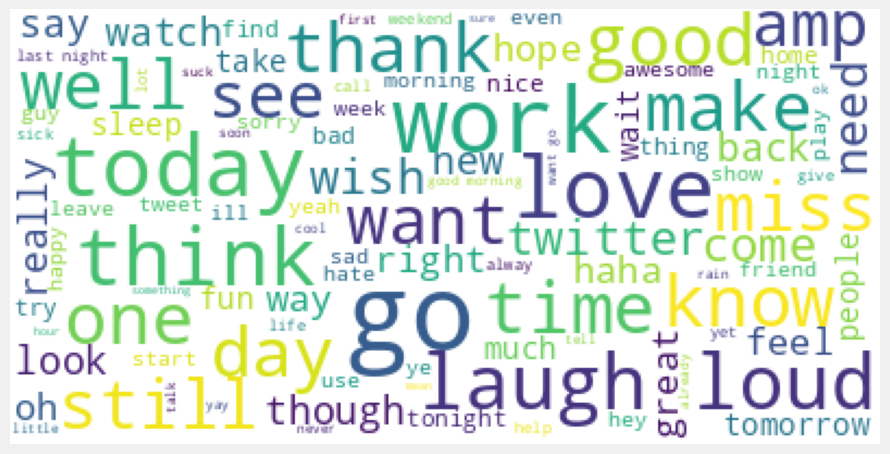

In [40]:
# Plotting wordcloud
wordcloud = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color = 'white').generate(all_text)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(wordcloud)
ax.axis('off')
plt.show()

#### Generating N-grams
- N-grams are continuous sequences of words, symbols or tokens in a document. Alternatively, they are neighbouring sequences of items, with length = N.
- Reference: https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#3.-Target-and-N-grams

In [41]:
### Helper Functions
# As most of the lemmatized tweets are not very long, we shall limit our ngrams to n = 3
def generate_bigrams(text): # bigrams, N = 2
    return list(ngrams(text.split(), n = 2))

def generate_trigrams(text): # trigrams, N = 2
    return list(ngrams(text.split(), n = 3))

In [42]:
df['bigram'] = df['text_lemmatized'].apply(lambda x: generate_bigrams(x)) # get bigrams
df['trigram'] = df['text_lemmatized'].apply(lambda x: generate_trigrams(x)) # get trigrams

In [43]:
positive_bigrams = defaultdict(int) # class labelled 1
negative_bigrams = defaultdict(int) # class labelled 0

for bigrams in df[df['label'] == 1]['bigram']: # get bigrams for positive class
    for bigram in bigrams:
        positive_bigrams[bigram] += 1
        
for bigrams in df[df['label'] == 0]['bigram']: # get bigrams for negative class
    for bigram in bigrams:
        negative_bigrams[bigram] += 1
        
positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key = lambda x: x[1])[::-1])
negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key = lambda x: x[1])[::-1])

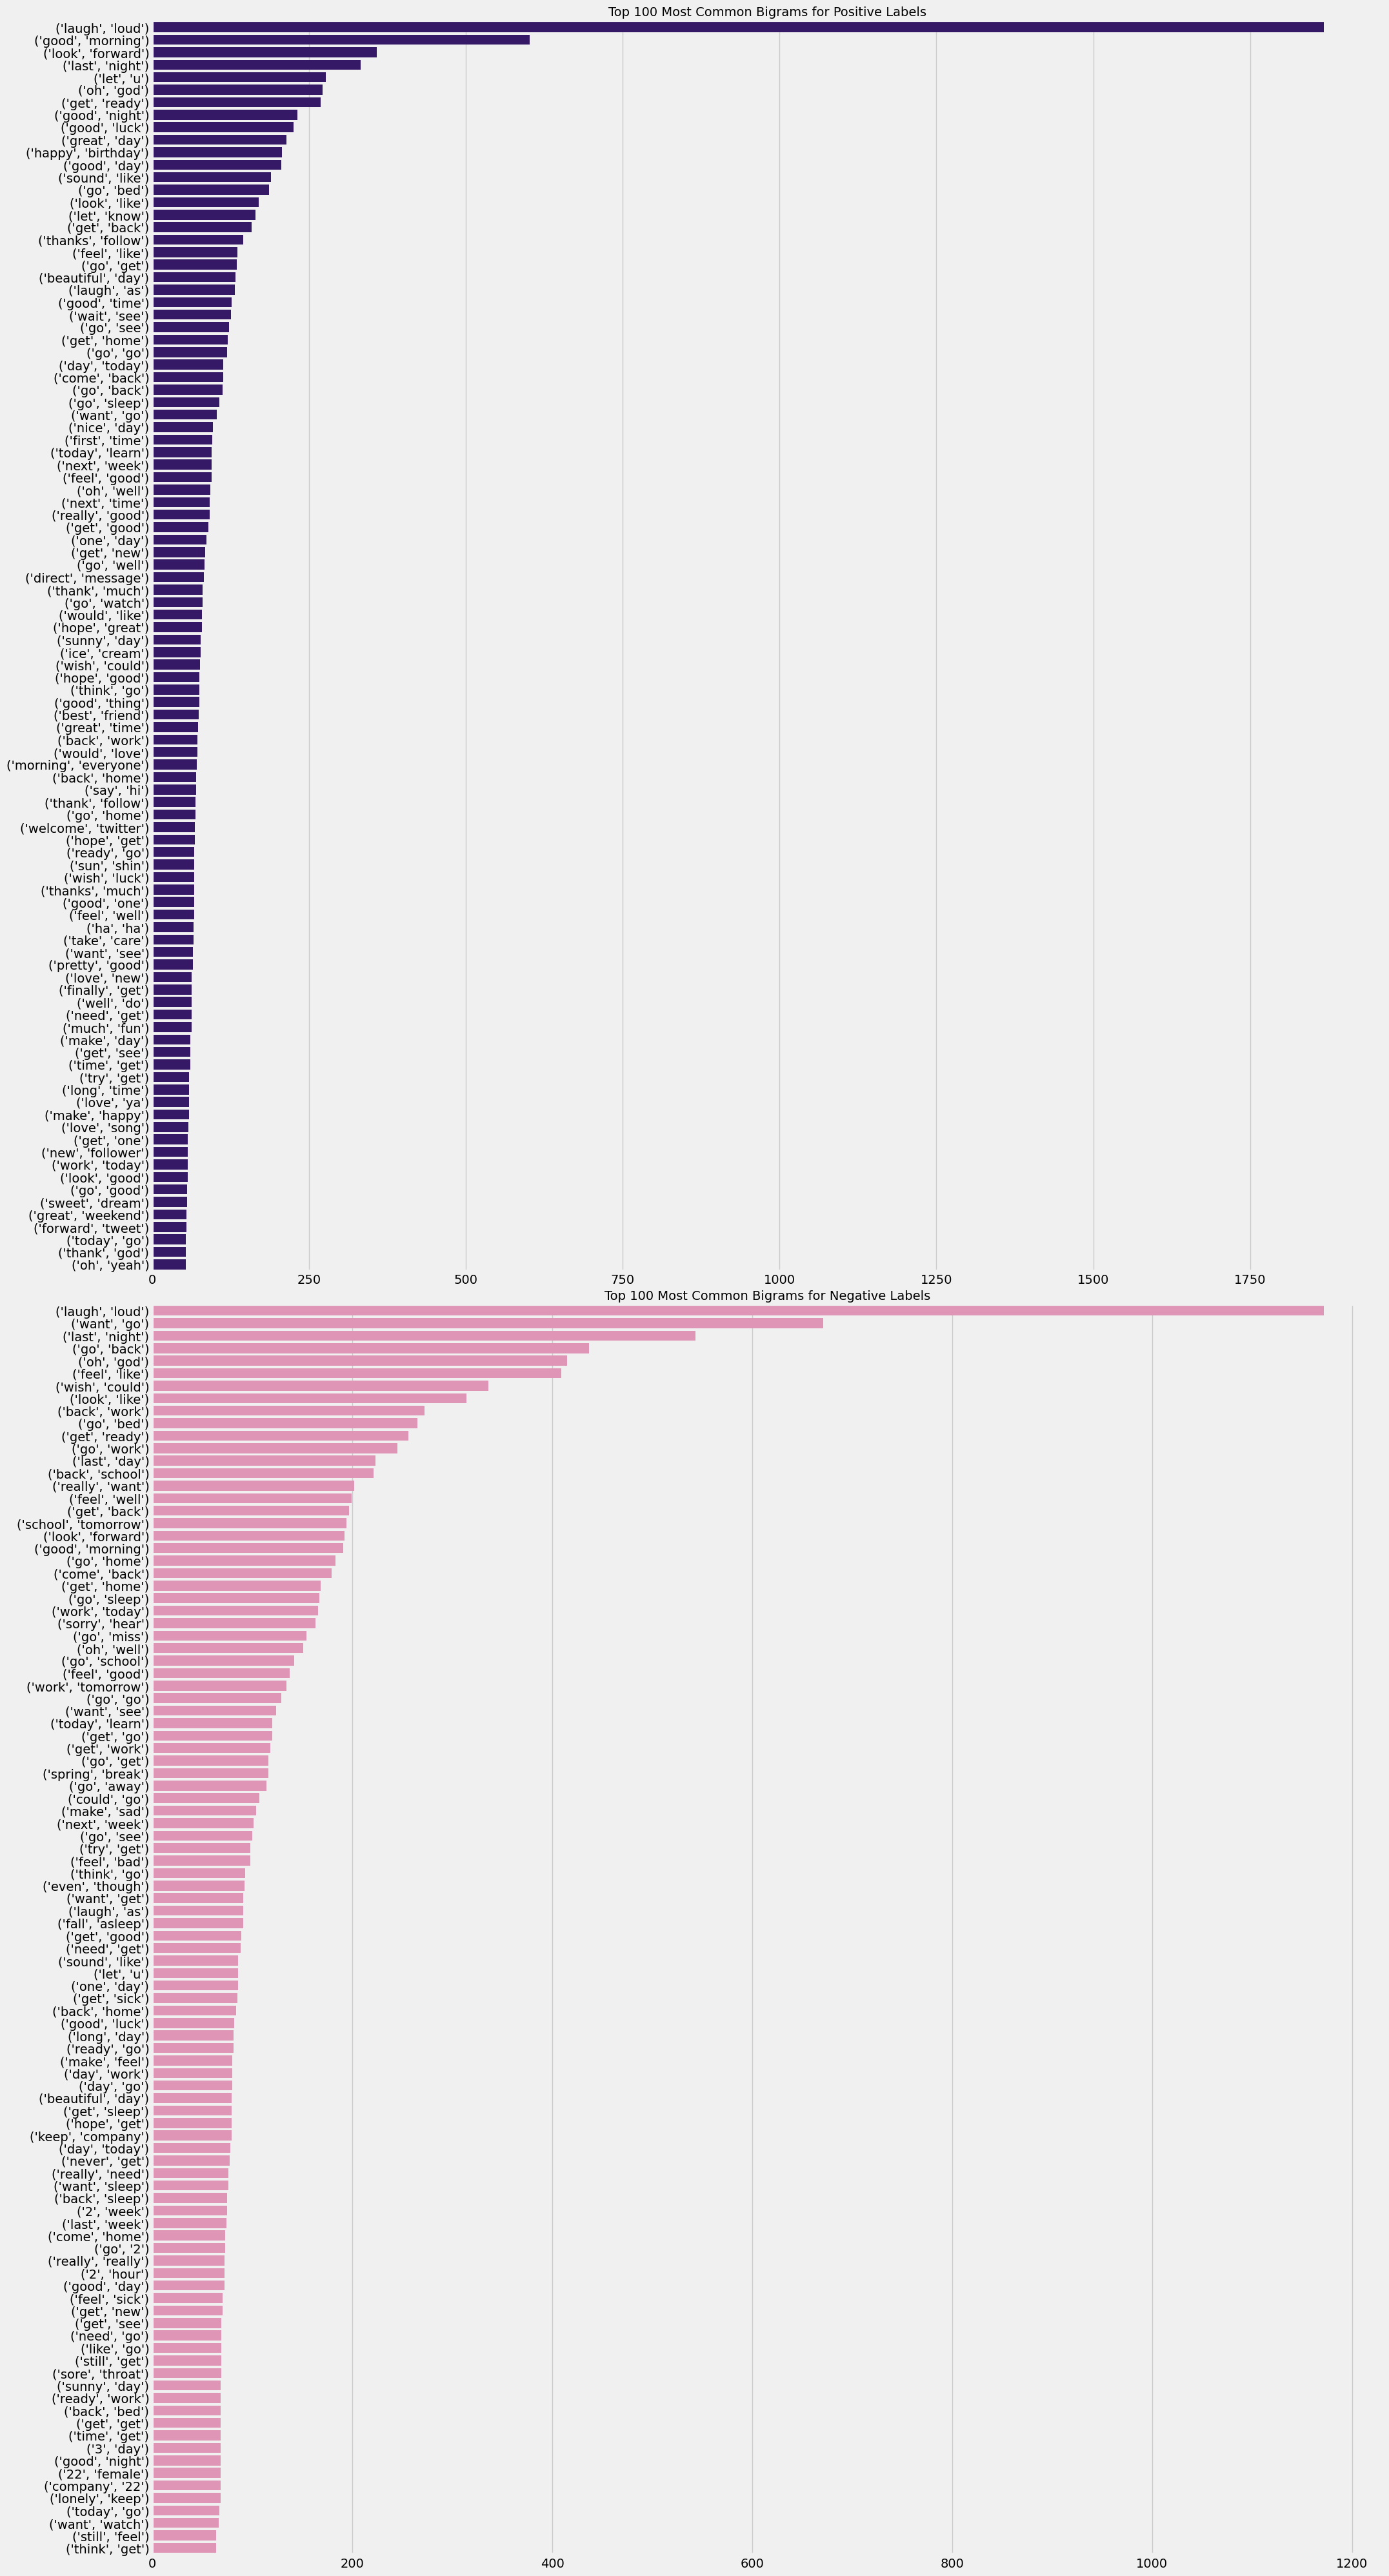

In [44]:
# Plotting bigrams grouped by positive and negative labels
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 40))
plt.tight_layout()
sns.barplot(x = positive_bigrams[1].values[:100], y = positive_bigrams[0].values[:100], ax = axs[0], color = '#330C73')
sns.barplot(x = negative_bigrams[1].values[:100], y = negative_bigrams[0].values[:100], ax = axs[1], color = '#EB89B5')

axs[0].set_title("Top 100 Most Common Bigrams for Positive Labels", fontsize = 14)
axs[1].set_title("Top 100 Most Common Bigrams for Negative Labels", fontsize = 14)

plt.show()

In [45]:
positive_trigrams = defaultdict(int) # class labelled 1
negative_trigrams = defaultdict(int) # class labelled 0

for trigrams in df[df['label'] == 1]['trigram']: # get trigrams for positive class
    for trigram in trigrams:
        positive_trigrams[trigram] += 1
        
for trigrams in df[df['label'] == 0]['trigram']: # get trigrams for negative class
    for trigram in trigrams:
        negative_trigrams[trigram] += 1
        
positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key = lambda x: x[1])[::-1])
negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key = lambda x: x[1])[::-1])

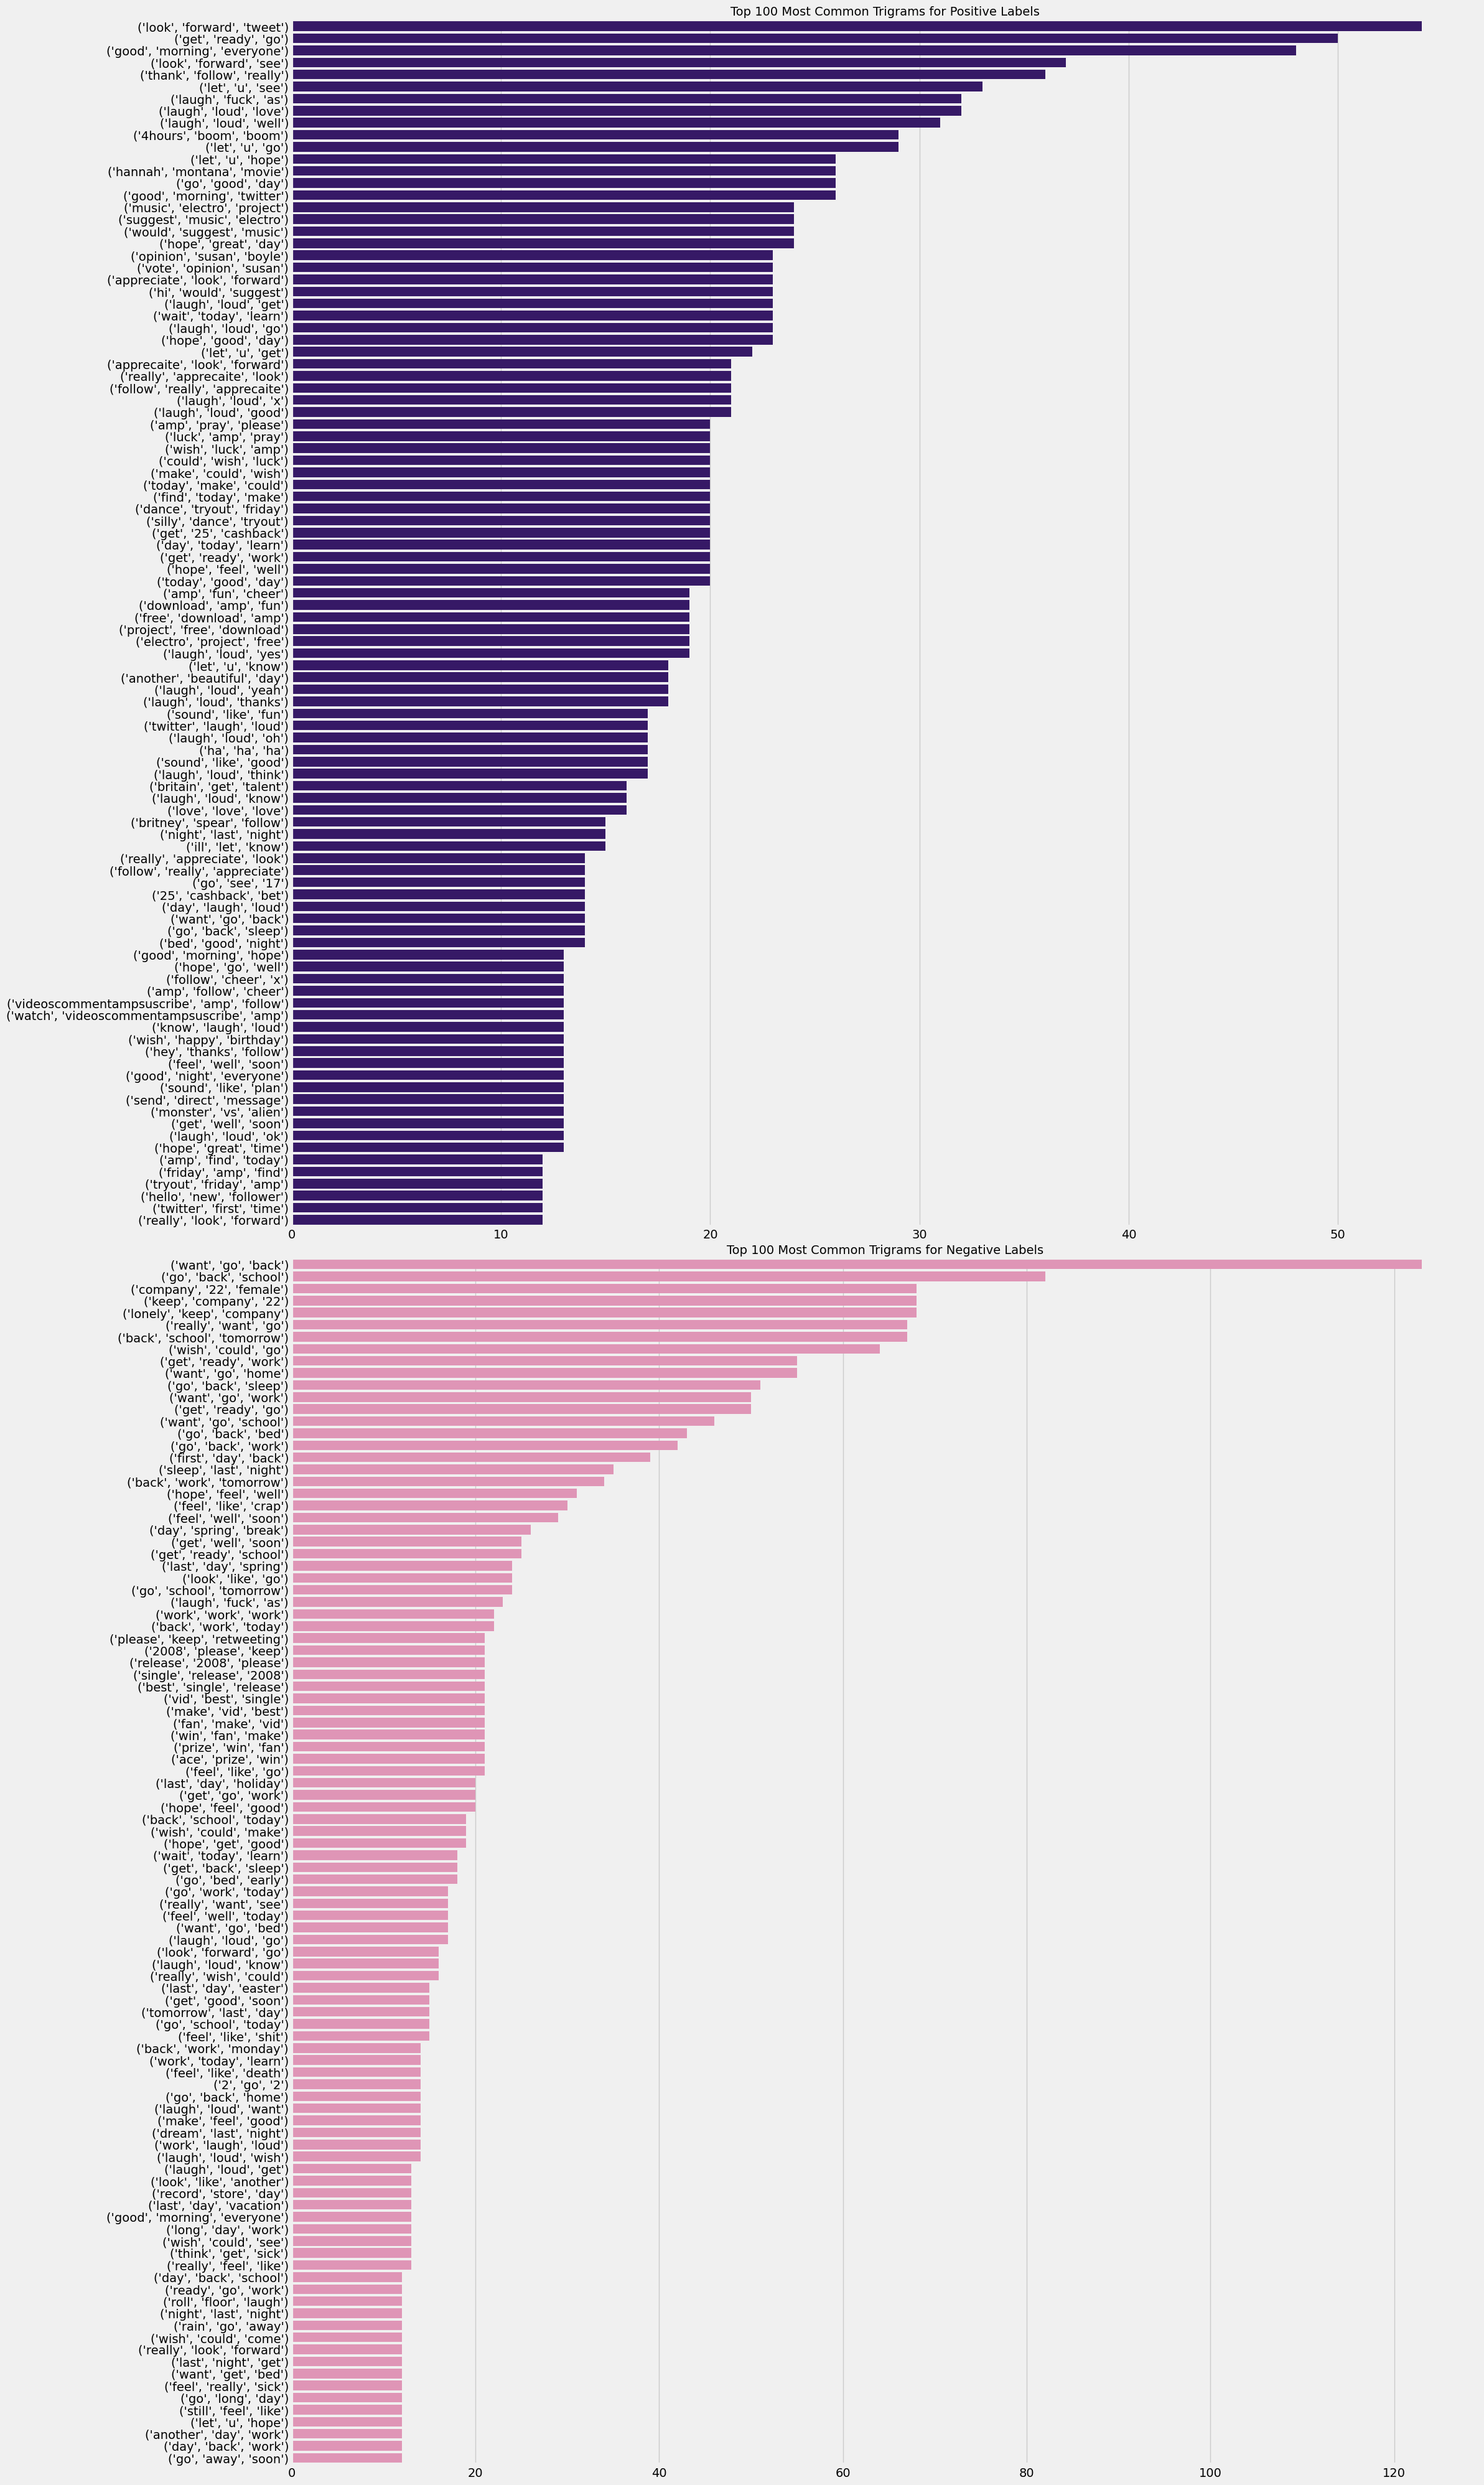

In [46]:
# Plotting trigrams grouped by positive and negative labels
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 40))
plt.tight_layout()
sns.barplot(x = positive_trigrams[1].values[:100], y = positive_trigrams[0].values[:100], ax = axs[0], color = '#330C73')
sns.barplot(x = negative_trigrams[1].values[:100], y = negative_trigrams[0].values[:100], ax = axs[1], color = '#EB89B5')

axs[0].set_title("Top 100 Most Common Trigrams for Positive Labels", fontsize = 14)
axs[1].set_title("Top 100 Most Common Trigrams for Negative Labels", fontsize = 14)

plt.show()

### Train Test Split

In [47]:
X = df['text_lemmatized']
y = df['label']

## stratified splitting of dataset into train and test in a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0) 

train = pd.concat([y_train, X_train], axis = 1)
test = pd.concat([y_test, X_test], axis = 1)

print(train.sort_index().head())
print('no. of rows of train = ' + str(len(train)))
print(train.label.value_counts())
print('\n')
print(test.sort_index().head())
print('no. of rows of test = ' + str(len(test)))
print(test.label.value_counts())

   label                                    text_lemmatized
0      0       awww bummer shoulda get david carr third day
1      0  upset update facebook texting might cry result...
3      0                    whole body feel itchy like fire
4      0                                     behave mad see
6      0                                           need hug
no. of rows of train = 70000
0    35000
1    35000
Name: label, dtype: int64


    label                                   text_lemmatized
2       0  dive many time ball manage save 50 rest go bound
5       0                                        whole crew
10      0                   spring break plain city snowing
11      0                                     repierced ear
13      0              count know either never talk anymore
no. of rows of test = 30000
0    15000
1    15000
Name: label, dtype: int64


### Vectorization for NLP

In [48]:
vectorizer = CountVectorizer() # converts text to token counts

X_train_v = vectorizer.fit_transform(X_train) # fits and vectorizes text in training set
X_test_v = vectorizer.transform(X_test) # vectorize text in testing set

## Modelling

We will use a randomized search on hyperparameters to tune our models, which tries a specified number of parameters sampled from a specified parameter distribution. Of course, this is a less rigorous method as compared to a grid search, which tries every possible combination of parameters available; however, this comes at the cost of an extremely long training time (up to several hours per model), given the large number of data points we have in our training set as well. Therefore, we shall settle for a randomized search, which yields a slightly worse performance as compared to grid search (that is still better than baseline) but is able to complete the tuning process in a fraction of the time.

In [57]:
### Helper function
def get_scores(y_test, y_pred):
    """
    Input: Actual Labels, Predicted Labels
    Output: Accuracy, Precision, F1-Score and Recall
    """
    acc = accuracy_score(y_test, y_pred) 
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return [acc, prec, f1, recall]

We will first implement a baseline model where applicable, using the default hyperparameters offered. After making predictions and generating evaluation metrics using the baseline model, we will tune the hyperparameters and make new predictions again to compare the metrics before and after tuning.

### Logistic Regression

In [ ]:
logreg_base = LogisticRegression() # Base model without tuning

logreg_base.fit(X_train_v, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
logreg_pred_base = logreg_base.predict(X_test_v)
logreg_scores_base = get_scores(y_test, logreg_pred_base)

Accuracy: 0.7447666666666667
Precision: 0.7350662654459312
Recall: 0.7654
F1-Score: 0.7499265162154217


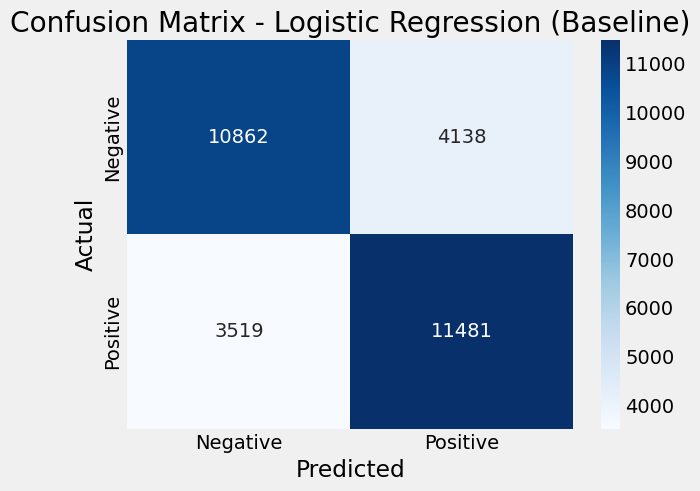

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     15000
           1       0.74      0.77      0.75     15000

    accuracy                           0.74     30000
   macro avg       0.75      0.74      0.74     30000
weighted avg       0.75      0.74      0.74     30000



In [ ]:
# Generating evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, logreg_pred_base)))
print('Precision: {}'.format(precision_score(y_test, logreg_pred_base)))
print('Recall: {}'.format(recall_score(y_test, logreg_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, logreg_pred_base)))

logreg_cm = confusion_matrix(y_test, logreg_pred_base)

sns.heatmap(logreg_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, logreg_pred_base))

#### Tuning Logistic Regression

In [ ]:
# ### Logistic Regression with Tuning
# logreg = LogisticRegression()

# # Parameter distribution for tuning
# param_grid = {
#     'C' : np.logspace(-4, 4, 20),
#     'penalty' : ['l2', 'none'], # type of regularization
#     'max_iter' : [100, 250, 500, 1000, 2500] # number of iterations
# }

# # Randomized search on parameter distribution for 50 combinations, with 3 cross-validations per combination
# clf = RandomizedSearchCV(logreg, param_distributions = param_grid, cv = 3, n_iter = 50, 
#                          n_jobs = -1, verbose = 5, random_state = 42)

# clf.fit(X_train_v, y_train)

In [ ]:
# print(clf.best_params_) # best parameters

In [ ]:
# print(clf.best_score_) # score obtained with best parameters

With a randomized search conducted on the parameter grid, we obtain the hyperparameters {'penalty': 'l2', 'max_iter': 250, 'C': 0.23357214690901212}.

In [ ]:
logreg_clf = LogisticRegression(penalty = 'l2', max_iter = 250, C = 0.23357214690901212) # initialise model

logreg_clf.fit(X_train_v, y_train) # fit model to data

LogisticRegression(C=0.23357214690901212, max_iter=250)

In [ ]:
logreg_pred = logreg_clf.predict(X_test_v) # generate predictions
logreg_scores = get_scores(y_test, logreg_pred)

Accuracy: 0.7465666666666667
Precision: 0.7329470302953959
Recall: 0.7758
F1-Score: 0.7537649383035917


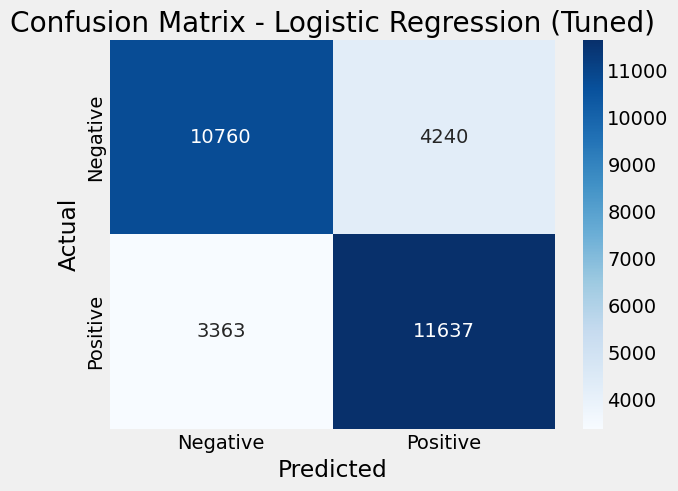

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     15000
           1       0.73      0.78      0.75     15000

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000



In [ ]:
# Generating evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, logreg_pred)))
print('Precision: {}'.format(precision_score(y_test, logreg_pred)))
print('Recall: {}'.format(recall_score(y_test, logreg_pred)))
print('F1-Score: {}'.format(f1_score(y_test, logreg_pred)))

logreg_cm = confusion_matrix(y_test, logreg_pred)

sns.heatmap(logreg_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.show()
print('-'*60)
print(classification_report(y_test, logreg_pred))

#### Model Comparison: Logistic Regression

In [ ]:
logreg_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
logreg_df['Model'] = ['Logistic Regression (Baseline)', 'Logistic Regression (Tuned)']
logreg_df['Accuracy'] = [logreg_scores_base[0], logreg_scores[0]]
logreg_df['Precision'] = [logreg_scores_base[1], logreg_scores[1]]
logreg_df['F1-Score'] = [logreg_scores_base[2], logreg_scores[2]]
logreg_df['Recall'] = [logreg_scores_base[3], logreg_scores[3]]
logreg_df.set_index('Model', inplace = True)

display(logreg_df)

Accuracy  Precision  Recall  F1-Score
Model                                                                
Logistic Regression (Baseline)  0.744767   0.735066  0.7654  0.749927
Logistic Regression (Tuned)     0.746567   0.732947  0.7758  0.753765

After tuning, evaluation metrics rose across the board (except precision which is understandable due to the precision-recall tradoff), albeit by a very small amount.

### Random Forest
Reference: 
- https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

In [ ]:
rf_clf_base = RandomForestClassifier(random_state = 42) # Base model without tuning
rf_clf_base.fit(X_train_v, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_pred_base = rf_clf_base.predict(X_test_v) # generate predictions
rf_scores_base = get_scores(y_test, rf_pred_base)

Accuracy: 0.7305
Precision: 0.728655512201574
Recall: 0.7345333333333334
F1-Score: 0.7315826167789915


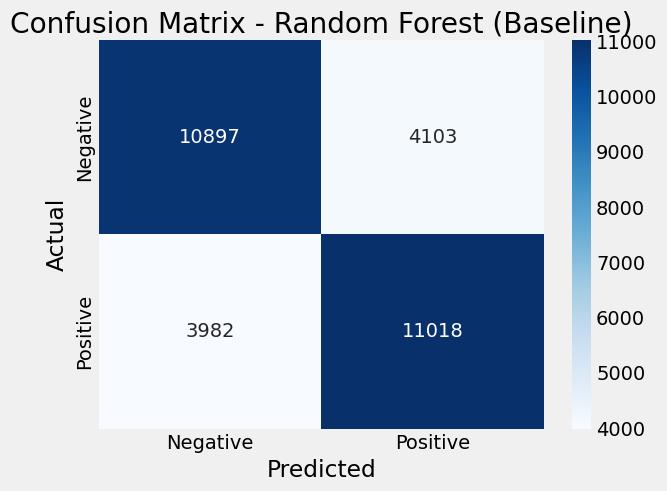

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     15000
           1       0.73      0.73      0.73     15000

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000



In [ ]:
# Generating evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, rf_pred_base)))
print('Precision: {}'.format(precision_score(y_test, rf_pred_base)))
print('Recall: {}'.format(recall_score(y_test, rf_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, rf_pred_base)))

logreg_cm = confusion_matrix(y_test, rf_pred_base)

sns.heatmap(logreg_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, rf_pred_base))

#### Tuning Random Forest

In [ ]:
# # n_estimators: number of trees in forest
# # min_samples_split: minimum number of samples required to split an internal node
# # min_samples_leaf: minimum number of samples required to be at a leaf node
# # max_depth: depth of tree; deeper trees have more splits

# # get parameter grid for tuning
# param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 250, stop = 2000, num = 10)], 
#               'min_samples_split' : [2,3,5,10,12],
#               'min_samples_leaf' : [1,2,4,6], 
#               'max_depth' : [3,5,7,9,11]}

In [ ]:
# # initialise random forest model
# rf_clf = RandomForestClassifier(random_state = 42)

# # 3 fold cross validation on 50 combinations
# clf = RandomizedSearchCV(estimator = rf_clf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose = 10,
#                         random_state = 42, n_jobs = -1)

# # fit model
# clf.fit(X_train_v, y_train)

In [ ]:
# print(clf.best_params_)

In [ ]:
# print(clf.best_score_)

With a randomized search, we obtain the best hyperparameters of {'n_estimators': 1416,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 11}, netting a score of 0.729.

In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 1416, min_samples_split = 5, min_samples_leaf = 1, 
                                max_depth = 11, random_state = 42) # initialise model

rf_clf.fit(X_train_v, y_train) # fit model to data

RandomForestClassifier(max_depth=11, min_samples_split=5, n_estimators=1416,
                       random_state=42)

In [ ]:
rf_pred = rf_clf.predict(X_test_v) # generate predictions
rf_scores = get_scores(y_test, rf_pred)

Accuracy: 0.7286
Precision: 0.7034290460370195
Recall: 0.7904666666666667
F1-Score: 0.7444123556002009


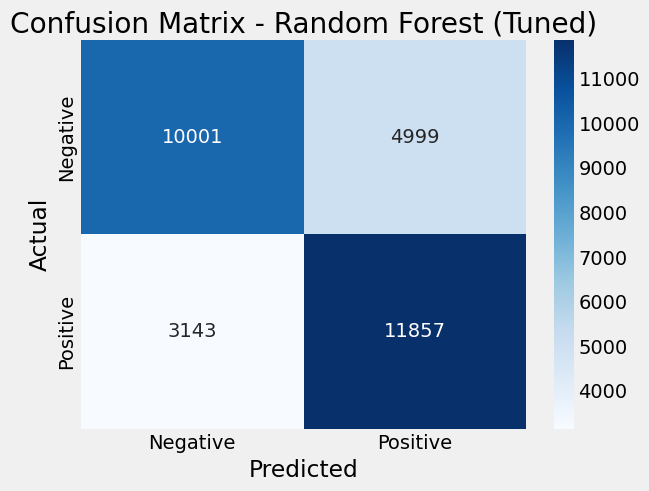

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.67      0.71     15000
           1       0.70      0.79      0.74     15000

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000



In [ ]:
# Generating evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, rf_pred)))
print('Precision: {}'.format(precision_score(y_test, rf_pred)))
print('Recall: {}'.format(recall_score(y_test, rf_pred)))
print('F1-Score: {}'.format(f1_score(y_test, rf_pred)))

logreg_cm = confusion_matrix(y_test, rf_pred)

sns.heatmap(logreg_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.show()
print('-'*60)
print(classification_report(y_test, rf_pred))

#### Model Comparison: Random Forest

In [ ]:
rf_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
rf_df['Model'] = ['Random Forest (Baseline)', 'Random Forest (Tuned)']
rf_df['Accuracy'] = [rf_scores_base[0], rf_scores[0]]
rf_df['Precision'] = [rf_scores_base[1], rf_scores[1]]
rf_df['F1-Score'] = [rf_scores_base[2], rf_scores[2]]
rf_df['Recall'] = [rf_scores_base[3], rf_scores[3]]
rf_df.set_index('Model', inplace = True)

display(rf_df)

Accuracy  Precision    Recall  F1-Score
Model                                                            
Random Forest (Baseline)    0.7305   0.728656  0.734533  0.731583
Random Forest (Tuned)       0.7286   0.703429  0.790467  0.744412

After tuning, the accuracy fell slightly but recall and F1-Score rose by a noticeable amount.

### Naive Bayes
References: 
- https://www.analyticsvidhya.com/blog/2021/07/performing-sentiment-analysis-with-naive-bayes-classifier/
- https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91

In [ ]:
mnb = MultinomialNB() # initialise model
mnb.fit(X_train_v, y_train) # fit model to training data

MultinomialNB()

In [ ]:
mnb_pred = mnb.predict(X_test_v) # generate predictions
mnb_scores = get_scores(y_test, mnb_pred)

Accuracy: 0.7407
Precision: 0.7542068577061184
Recall: 0.7141333333333333
F1-Score: 0.7336232578844638


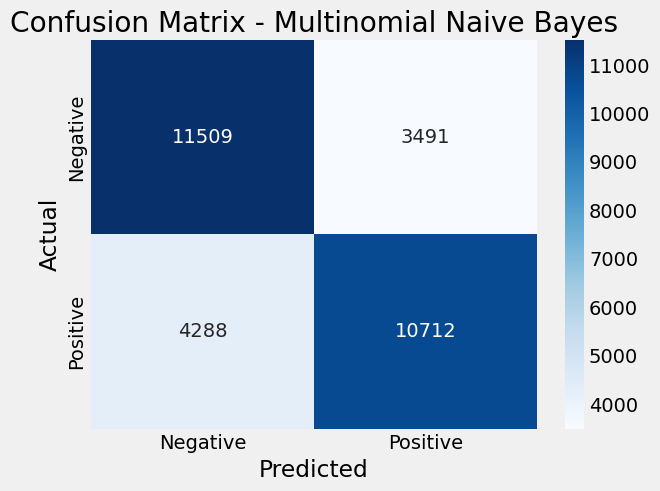

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     15000
           1       0.75      0.71      0.73     15000

    accuracy                           0.74     30000
   macro avg       0.74      0.74      0.74     30000
weighted avg       0.74      0.74      0.74     30000



In [ ]:
# Generate evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, mnb_pred)))
print('Precision: {}'.format(precision_score(y_test, mnb_pred)))
print('Recall: {}'.format(recall_score(y_test, mnb_pred)))
print('F1-Score: {}'.format(f1_score(y_test, mnb_pred)))

mnb_cm = confusion_matrix(y_test, mnb_pred)

sns.heatmap(mnb_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.show()
print('-'*60)
print(classification_report(y_test, mnb_pred))

### Support Vector Machine
Reference:
- https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

In [ ]:
svc_base = SVC() # Base model with tuning
svc_base.fit(X_train_v, y_train)

SVC()

In [ ]:
svc_pred_base = svc_base.predict(X_test_v) # generate predictions
svc_scores_base = get_scores(y_test, svc_pred_base)

Accuracy: 0.7502
Precision: 0.7327008928571429
Recall: 0.7878
F1-Score: 0.7592521202775636


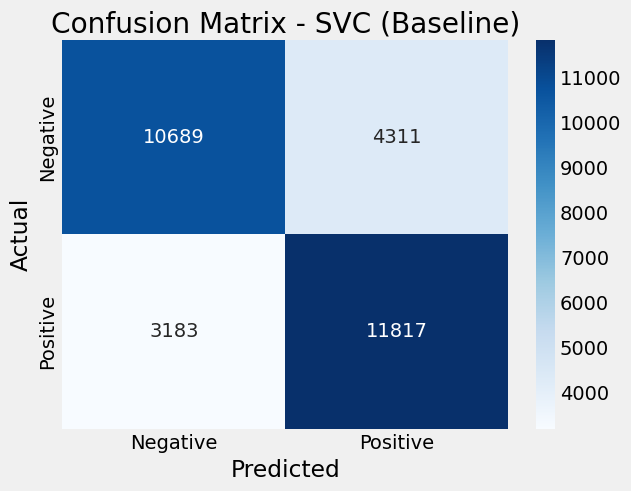

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     15000
           1       0.73      0.79      0.76     15000

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000



In [ ]:
# Generate evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, svc_pred_base)))
print('Precision: {}'.format(precision_score(y_test, svc_pred_base)))
print('Recall: {}'.format(recall_score(y_test, svc_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, svc_pred_base)))

svc_cm = confusion_matrix(y_test, svc_pred_base)

sns.heatmap(svc_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVC (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, svc_pred_base))

#### Tuning Support Vector Machine

In [ ]:
# ### Initialise parameter distribution for tuning

# # Cost: Regularization parameter which penalizes misclassification of data points
# # Kernel: Specification of transformation to be applied to data
# # Gamma: Proximity of points to be considered for which determine the line of separation

# param_grid = {
#     'C' : np.logspace(-4, 4, 20),
#     'kernel' : ['rbf', 'poly'],
#     'gamma' : ['scale', 'auto'],
# }

# svc = SVC() # initialise model

# # # randomized search on parameter distribution for 10 combinations with 3 cross-validations per combination
# clf = RandomizedSearchCV(svc, param_distributions = param_grid, cv = 3, n_iter = 10, 
#                          n_jobs = -1, verbose = 10, random_state = 42)

# clf.fit(X_train_v, y_train) # warning: this will take a very long time to run!

In [ ]:
# clf.best_params_

With a randomized search, we obtain the best hyperparameters of {kernel = 'rbf', gamma = 'scale', C = 1.623776739188721}.

In [ ]:
svc = SVC(kernel = 'rbf', gamma = 'scale', C = 1.623776739188721) # initialise model
svc.fit(X_train_v, y_train) # fit model to data

SVC(C=1.623776739188721)

In [ ]:
svc_pred = svc.predict(X_test_v) # generate predictions
svc_scores = get_scores(y_test, svc_pred)

Accuracy: 0.7512
Precision: 0.7358242583552385
Recall: 0.7838
F1-Score: 0.7590548130931629


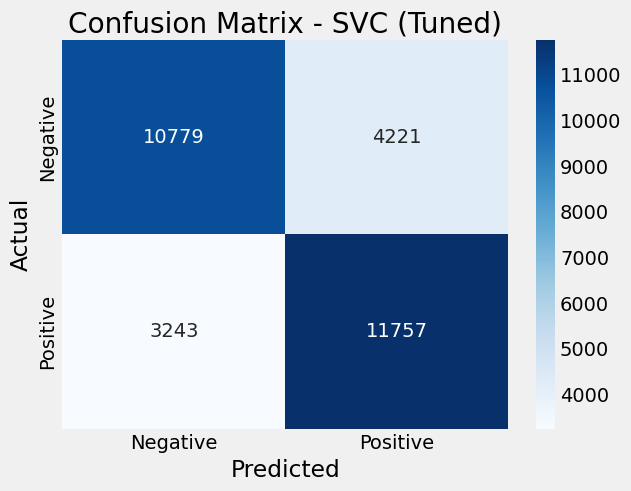

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     15000
           1       0.74      0.78      0.76     15000

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000



In [ ]:
# Generate evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, svc_pred)))
print('Precision: {}'.format(precision_score(y_test, svc_pred)))
print('Recall: {}'.format(recall_score(y_test, svc_pred)))
print('F1-Score: {}'.format(f1_score(y_test, svc_pred)))

svc_cm = confusion_matrix(y_test, svc_pred)

sns.heatmap(svc_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVC (Tuned)')
plt.show()
print('-'*60)
print(classification_report(y_test, svc_pred))

In [ ]:
svc_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
svc_df['Model'] = ['SVM (Baseline)', 'SVM (Tuned)']
svc_df['Accuracy'] = [svc_scores_base[0], svc_scores[0]]
svc_df['Precision'] = [svc_scores_base[1], svc_scores[1]]
svc_df['F1-Score'] = [svc_scores_base[2], svc_scores[2]]
svc_df['Recall'] = [svc_scores_base[3], svc_scores[3]]
svc_df.set_index('Model', inplace = True)

display(svc_df)

Accuracy  Precision  Recall  F1-Score
Model                                                
SVM (Baseline)    0.7502   0.732701  0.7878  0.759252
SVM (Tuned)       0.7512   0.735824  0.7838  0.759055

After tuning, accuracy rises by an insignificant amount but F1-Score falls slightly. Overall, tuning the model does not have a noticeable impact here.

### Stochastic Gradient Descent
References:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
- https://realpython.com/gradient-descent-algorithm-python/

In [ ]:
sgdc_base = SGDClassifier() # Base model without tuning
sgdc_base.fit(X_train_v, y_train) 

SGDClassifier()

In [ ]:
sgdc_pred_base = sgdc_base.predict(X_test_v) # generate predictions
sgdc_scores_base = get_scores(y_test, sgdc_pred_base)

Accuracy: 0.7454666666666667
Precision: 0.724184120798831
Recall: 0.7929333333333334
F1-Score: 0.7570010183299389


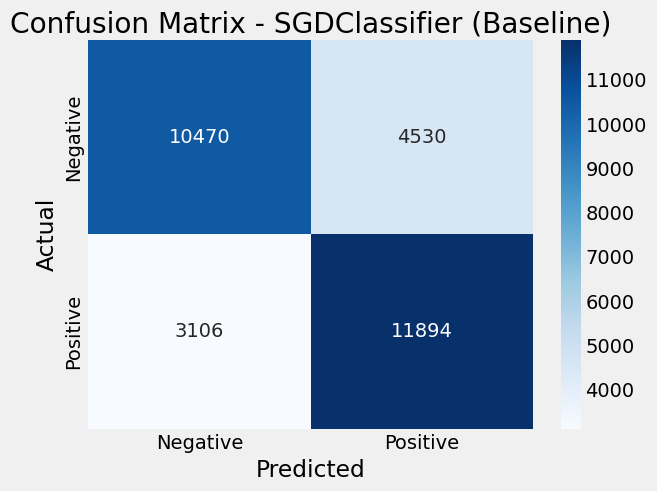

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.70      0.73     15000
           1       0.72      0.79      0.76     15000

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.74     30000
weighted avg       0.75      0.75      0.74     30000



In [ ]:
# Generate evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, sgdc_pred_base)))
print('Precision: {}'.format(precision_score(y_test, sgdc_pred_base)))
print('Recall: {}'.format(recall_score(y_test, sgdc_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, sgdc_pred_base)))

sgdc_cm = confusion_matrix(y_test, sgdc_pred_base)

sns.heatmap(sgdc_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGDClassifier (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, sgdc_pred_base))

#### Tuning Stochastic Gradient Descent

In [ ]:
# ### Initialise parameter distribution for tuning

# # Loss function: Function to be maximized or minimized in the training process

# param_grid = {'loss' : ['hinge', 'log_loss', 'squared_hinge', 'perceptron', 'squared_error',
#                         'modified_huber', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#               'penalty' : ['l2', 'l1', 'elasticnet'],
#               'max_iter' : [1000, 2000, 3000, 4000]
#               }

# sgdc = SGDClassifier() # initialise model

# # randomized search on parameter distribution for 100 combinations with 3 cross-validations per combination
# clf = RandomizedSearchCV(sgdc, param_distributions = param_grid, cv = 3, n_iter = 108, 
#                          n_jobs = -1, verbose = 10, random_state = 42)
# clf.fit(X_train_v, y_train)

In [ ]:
# print(clf.best_params_)

With a randomized search, we obtain the best parameters of {'penalty': 'l2', 'max_iter': 1000, 'loss': 'log_loss'}.

In [ ]:
sgdc = SGDClassifier(loss = 'log_loss', penalty = 'l2', max_iter = 1000) # initialise model
sgdc.fit(X_train_v, y_train) # fit model to training data

SGDClassifier(loss='log_loss')

In [ ]:
sgdc_pred = sgdc.predict(X_test_v) # generate predictions
sgdc_scores = get_scores(y_test, sgdc_pred)

Accuracy: 0.7448
Precision: 0.728046205440318
Recall: 0.7815333333333333
F1-Score: 0.7538421966433027


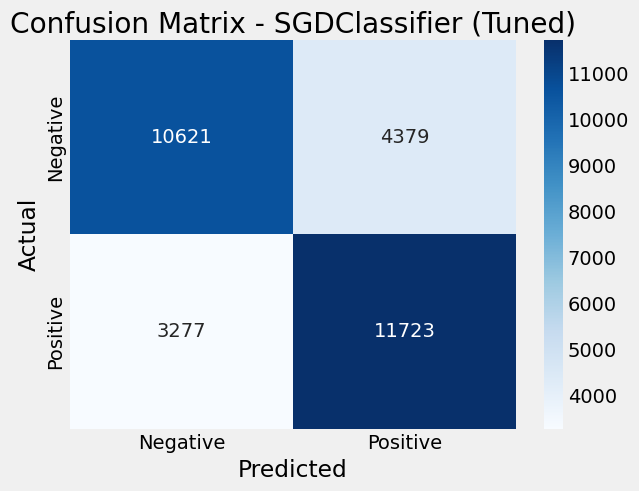

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.71      0.74     15000
           1       0.73      0.78      0.75     15000

    accuracy                           0.74     30000
   macro avg       0.75      0.74      0.74     30000
weighted avg       0.75      0.74      0.74     30000



In [ ]:
# Generate evaluation metrics
print('Accuracy: {}'.format(accuracy_score(y_test, sgdc_pred)))
print('Precision: {}'.format(precision_score(y_test, sgdc_pred)))
print('Recall: {}'.format(recall_score(y_test, sgdc_pred)))
print('F1-Score: {}'.format(f1_score(y_test, sgdc_pred)))

sgdc_cm = confusion_matrix(y_test, sgdc_pred)

sns.heatmap(sgdc_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGDClassifier (Tuned)')
plt.show()
print('-'*60)
print(classification_report(y_test, sgdc_pred))

In [ ]:
sgdc_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
sgdc_df['Model'] = ['Stochastic Gradient Descent (Baseline)', 'Stochastic Gradient Descent (Tuned)']
sgdc_df['Accuracy'] = [sgdc_scores_base[0], sgdc_scores[0]]
sgdc_df['Precision'] = [sgdc_scores_base[1], sgdc_scores[1]]
sgdc_df['F1-Score'] = [sgdc_scores_base[2], sgdc_scores[2]]
sgdc_df['Recall'] = [sgdc_scores_base[3], sgdc_scores[3]]
sgdc_df.set_index('Model', inplace = True)

display(sgdc_df)

Accuracy  Precision    Recall  \
Model                                                                   
Stochastic Gradient Descent (Baseline)  0.745467   0.724184  0.792933   
Stochastic Gradient Descent (Tuned)     0.744800   0.728046  0.781533   

                                        F1-Score  
Model                                             
Stochastic Gradient Descent (Baseline)  0.757001  
Stochastic Gradient Descent (Tuned)     0.753842

Similar to the Support Vector Machine, tuning only increases accuracy by an insignificant amount while reducing F1-Score slightly. Overall, there is not much of a noticeable impact from tuning the Stochastic Gradient Descent model.

### XGBoost

References:
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb_clf_base = XGBClassifier(objective = 'binary:logistic',
                        seed = 42) # Base model without tuning

xgb_clf_base.fit(X_train_v, y_train) # fit model to training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
xgb_pred_base = xgb_clf_base.predict(X_test_v) # generate predictions
xgb_scores_base = get_scores(y_test, xgb_pred_base)

Accuracy: 0.7228666666666667
Precision: 0.6892764126373004
Recall: 0.8116
F1-Score: 0.7454534321229562


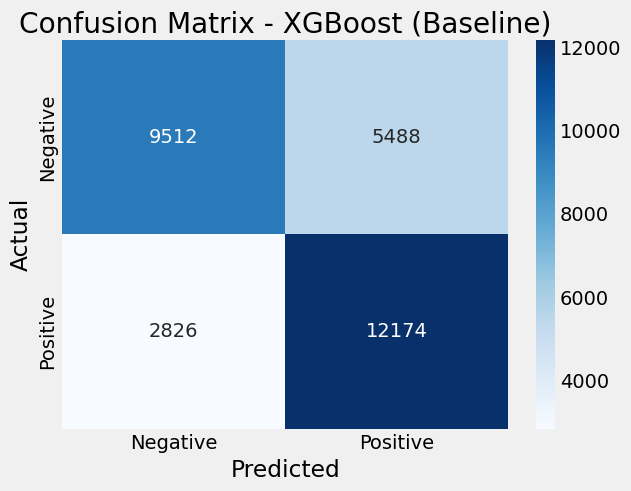

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.63      0.70     15000
           1       0.69      0.81      0.75     15000

    accuracy                           0.72     30000
   macro avg       0.73      0.72      0.72     30000
weighted avg       0.73      0.72      0.72     30000



In [ ]:
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_pred_base)))
print('Precision: {}'.format(precision_score(y_test, xgb_pred_base)))
print('Recall: {}'.format(recall_score(y_test, xgb_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, xgb_pred_base)))

xgb_cm = confusion_matrix(y_test, xgb_pred_base)

sns.heatmap(xgb_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, xgb_pred_base))

#### Tuning XGBoost

We shall tune our model using grid search for 4 different groups of hyperparameters:
1. `max_depth` and `min_child_weight`
2. `subsample` and `colsample_bytree`
3. `gamma`
4. `learning_rate`

In [ ]:
# ### Grid Search for max_depth and min_child_weight

# """
# max_depth refers to the maximum depth of each decision tree in the ensemble. Having deeper trees allow for a more complex
# and potentially accurate model but can result in overfitting.

# min_child_weight refers to the minimum amount of sample that should be present in each leaf node.
# """

# param_test1 = {'max_depth': range(3, 10, 2),
#               'min_child_weight': range(1, 6, 2)}

# grid_search1 = GridSearchCV(estimator = XGBClassifier(n_estimators = 1000, objective = 'binary:logistic',
#                                                      seed = 42),
#                                   param_grid = param_test1,
#                                   scoring = 'accuracy',
#                                   n_jobs = -1,  
#                                   cv = 3, 
#                                   verbose = 2)

# grid_search1.fit(X_train_v, y_train) # grid search on training data with specified parameter distribution

In [ ]:
# print('Best Params: ', grid_search1.best_params_)
# print('Best Score: ', grid_search1.best_score_)

Here, we obtain the best parameters of {'max_depth': 9, 'min_child_weight': 1}.

In [ ]:
# ### Grid Search for subsample and colsample_bytree

# """
# subsample refers to the faction of samples used for each tree. This controls the randomness of each tree.
# colsample_bytree refers to the fraction of features used for each tree. This controls the number of features
# to be considered when splitting each node in the tree.
# """
# param_test2 = {'subsample': [0.2, 0.3, 0.4, 0.5],
#               'colsample_bytree': [0.3, 0.4, 0.5, 0.6]}

# grid_search2 = GridSearchCV(estimator = XGBClassifier(n_estimators = 1000, 
#                                                       max_depth = 9,
#                                                       min_child_weight = 1,
#                                                       objective = 'binary:logistic',
#                                                      seed = 42),
#                                   param_grid = param_test2,
#                                   scoring = 'accuracy',
#                                   n_jobs = -1,  
#                                   cv = 2, 
#                                   verbose = 2)

# grid_search2.fit(X_train_v, y_train) # grid search on training data with specified parameter distribution

In [ ]:
# print('Best Params: ', grid_search2.best_params_)
# print('Best Score: ', grid_search2.best_score_)

Here, we obtain the best parameters of {'colsample_bytree': 0.3, 'subsample': 0.5}

In [ ]:
# param_test3 = {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}

# grid_search3 = GridSearchCV(estimator = XGBClassifier(n_estimators = 1000, 
#                                                       max_depth = 9,
#                                                       min_child_weight = 1,
#                                                       objective = 'binary:logistic',
#                                                      seed = 42),
#                                   param_grid = param_test3,
#                                   scoring = 'accuracy',
#                                   n_jobs = -1,  
#                                   cv = 3, 
#                                   verbose = 2)

# grid_search3.fit(X_train_v, y_train) # grid search on training data with specified parameter distribution

In [ ]:
# print('Best Params: ', grid_search3.best_params_)
# print('Best Score: ', grid_search3.best_score_)

Here, we obtain the best parameters of {'gamma': 0.0}.

In [ ]:
# ### Grid Search for learning_rate

# # learning_rate refers to how quickly the model should learn from the mistakes it makes during training.
# # It should be tuned to control overfitting or underfitting.

# param_test4 = {'learning_rate' : [0.01, 0.1, 0.2]}

# grid_search4 = GridSearchCV(estimator = XGBClassifier(n_estimators = 1000, 
#                                                       max_depth = 9,
#                                                       min_child_weight = 1,
#                                                       gamma = 0.0,
#                                                       colsample_bytree = 0.3,
#                                                       subsample = 0.5,
#                                                       objective = 'binary:logistic',
#                                                      seed = 42),
#                                   param_grid = param_test4,
#                                   scoring = 'accuracy',
#                                   n_jobs = -1,  
#                                   cv = 3, 
#                                   verbose = 2)

# grid_search4.fit(X_train_v, y_train) # grid search on training data with specified parameter distribution

In [ ]:
# print('Best Params: ', grid_search4.best_params_)
# print('Best Score: ', grid_search4.best_score_)

Here, we obtain the best parameters of {'learning_rate': 0.1}.

In [ ]:
xgb_clf = XGBClassifier(n_estimators = 1000, 
                        max_depth = 9,
                        min_child_weight = 1,
                        gamma = 0.0,
                        colsample_bytree = 0.3,
                        subsample = 0.5,
                        objective = 'binary:logistic',
                        seed = 42) # initialise model with hyperparameters obtained from grid search

xgb_clf.fit(X_train_v, y_train) # fit model to training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
xgb_pred = xgb_clf.predict(X_test_v) # generate predictions
xgb_scores = get_scores(y_test, xgb_pred)

Accuracy: 0.7447
Precision: 0.7316503628905018
Recall: 0.7728666666666667
F1-Score: 0.7516939536391636


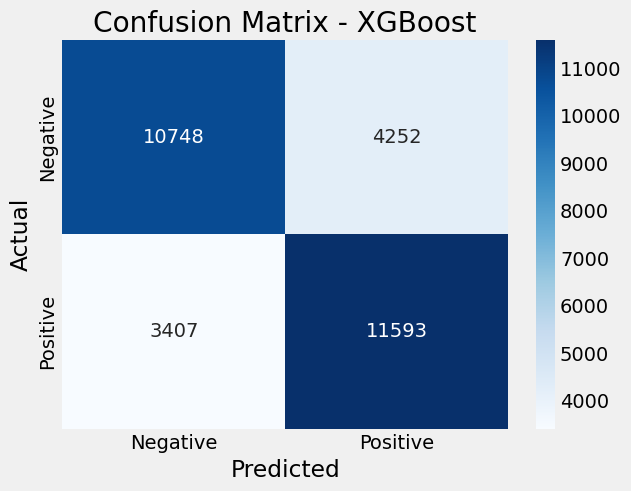

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     15000
           1       0.73      0.77      0.75     15000

    accuracy                           0.74     30000
   macro avg       0.75      0.74      0.74     30000
weighted avg       0.75      0.74      0.74     30000



In [ ]:
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_pred)))
print('Precision: {}'.format(precision_score(y_test, xgb_pred)))
print('Recall: {}'.format(recall_score(y_test, xgb_pred)))
print('F1-Score: {}'.format(f1_score(y_test, xgb_pred)))

xgb_cm = confusion_matrix(y_test, xgb_pred)

sns.heatmap(xgb_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.show()
print('-'*60)
print(classification_report(y_test, xgb_pred))

In [ ]:
xgb_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
xgb_df['Model'] = ['XGBoost (Baseline)', 'XGBoost (Tuned)']
xgb_df['Accuracy'] = [xgb_scores_base[0], xgb_scores[0]]
xgb_df['Precision'] = [xgb_scores_base[1], xgb_scores[1]]
xgb_df['F1-Score'] = [xgb_scores_base[2], xgb_scores[2]]
xgb_df['Recall'] = [xgb_scores_base[3], xgb_scores[3]]
xgb_df.set_index('Model', inplace = True)

display(xgb_df)

Accuracy  Precision    Recall  F1-Score
Model                                                      
XGBoost (Baseline)  0.722867   0.689276  0.811600  0.745453
XGBoost (Tuned)     0.744700   0.731650  0.772867  0.751694

Here, hyperparameter tuning produced a noticeable increase in accuracy by almost 2%, while increasing F1-Score slightly. Given the large number and complexity of hyperparameters to tune, it is likely that the accuracy may rise further with further tuning, for example by specifying a large range of hyperparameters and conducting more grid searches on the parameter distributions.

### LSTM 

Here, we will first implement two baseline LSTM models using basic tokenization and embeddings as a means for us to get accustomed to working with LSTM models. Lastly, we will implement a final LSTM model with GloVe vectorization, which is expected to possess the highest predictive power of the three.

#### LSTM With Basic Embedding

In [64]:
# Obtain max length to pad sequences
max_len = df.num_words_lemm.max()
print('Maximum length: {} words'.format(max_len))

Maximum length: 32 words


Here, we will tokenize the lemmatized text to create a new tokenized dataframe, then we will conduct train test split again before fitting our LSTM to the training data. We will also pad each of the tokenized text with leading zeros such that vector is of the same shape (32 columns)

In [65]:
tokenizer = Tokenizer() # create tokenizer with tensorflow
tokenizer.fit_on_texts(df['text_lemmatized'].values) # fit tokenizer to lemmatized text
X = tokenizer.texts_to_sequences(df['text_lemmatized'].values) # convert text to sequences

In [66]:
print('===============================================================')
print('Tokenized text before padding:\n================================')
for row in X[:5]:
    print(row)
    
X = pad_sequences(X, maxlen = max_len, padding = 'post') # pad tokenized text with zeros at the end

print('===============================================================')
print('Tokenized text after padding:')
print('===============================================================')
for row in X[:5]:
    print(row)

Tokenized text before padding:
[411, 1178, 3362, 2, 1179, 4948, 1545, 3]
[574, 225, 255, 2243, 202, 265, 776, 56, 7, 178, 952]
[2651, 201, 11, 897, 772, 480, 1022, 301, 1, 3476]
[324, 588, 24, 2244, 6, 876]
[3011, 543, 17]
Tokenized text after padding:
[ 411 1178 3362    2 1179 4948 1545    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[ 574  225  255 2243  202  265  776   56    7  178  952    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[2651  201   11  897  772  480 1022  301    1 3476    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[ 324  588   24 2244    6  876    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[3011  543   17    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0

In [67]:
# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)

In [68]:
print('Training: ', X_train.shape)
print('Testing: ', X_test.shape)

Training:  (70000, 32)
Testing:  (30000, 32)


Next, we will fit a Sequential LSTM model to our data.

References: 
- https://www.kaggle.com/code/jvkchaitanya410/twitter-sentiment-classification-using-lstm#Creating-our-Model
- https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [69]:
vocab_size = max([max(l) for l in X]) + 1 # vocabulary size + 1
output_dim = 50
input_length = X.shape[1]

In [70]:
model = Sequential() # initialise sequential model
# add embedding layer to map input sequences to dense vectors
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = input_length))
# add dropout layer with regularization that randomly sets a fraction of input channels to zero thereby preventing overfitting
model.add(SpatialDropout1D(0.15))
# add LSTM layer
model.add(LSTM(100, dropout = 0.15, recurrent_dropout = 0.15))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 50)            2924800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 32, 50)           0         
 ropout1D)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,990,301
Trainable params: 2,990,301
Non-trainable params: 0
____________________________________________

In [71]:
# checkpoint = ModelCheckpoint('weights.h5', monitor = 'loss', save_best_only = True) # save best weights from training
# early_stop = EarlyStopping(monitor = 'loss', patience = 3) # stop training after 3 epochs if no improvement
# history = model.fit(X_train, y_train, epochs = 25, batch_size = 64, callbacks = [checkpoint, early_stop], 
#                     use_multiprocessing = True) # fit model to training data with 25 epochs

In [72]:
model.load_weights('drive/MyDrive/IT1244_Team13_Project/Code/weights.h5')
model.evaluate(X_test, y_test) # evaluate model on testing data

938/938 [==============================] - 13s 13ms/step - loss: 1.3990 - accuracy: 0.7077


[1.399015188217163, 0.7076666951179504]

Here, we obtain an accuracy of 0.7064 on the testing dataset.

We can repeat the above, this time with a Bidirectional LSTM which uses two separate layers to process input data in two directions, forward and backwards. The backward layer processes the input sequence in the reverse direction on top of the forward layer which processes the input sequence in the usual forward direction, thereafter the output from each layer is concatenated to create a combined output that is then fed into the next output later.

In [73]:
model = Sequential() # initialise sequential model
# add embedding layer to map input sequences to dense vectors
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = input_length))
# add dropout layer with regularization that randomly sets a fraction of input channels to zero thereby preventing overfitting
model.add(SpatialDropout1D(0.15))
# add LSTM layer
model.add(Bidirectional(LSTM(100, dropout = 0.15, recurrent_dropout = 0.15, return_sequences = True)))
model.add(Bidirectional(LSTM(100, dropout = 0.15, recurrent_dropout = 0.15, return_sequences = True)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 50)            2924800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 32, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 32, 200)          120800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32, 200)          240800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32, 16)            3216      
                                                      

In [74]:
# checkpoint_b = ModelCheckpoint('weights2.hdf5', monitor = 'loss', save_best_only = True) # save best weights from training
# early_stop = EarlyStopping(monitor = 'loss', patience = 3) # stop training after 3 epochs if no improvement
# history_b = model.fit(X_train, y_train, epochs = 25, batch_size = 64, callbacks = [checkpoint_b, early_stop], 
#                     use_multiprocessing = True)

In [75]:
# ### Plotting training accuracy and loss 
# acc, loss = history_b.history['accuracy'], history_b.history['loss']
# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training Accuracy')
# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.title('Bidirectional LSTM - Training Accuracy and Loss')
# plt.legend()
# plt.show()

In [76]:
model.load_weights('drive/MyDrive/IT1244_Team13_Project/Code/weights2.hdf5')
model.evaluate(X_test, y_test)

938/938 [==============================] - 45s 46ms/step - loss: 1.6095 - accuracy: 0.7021


[1.6094863414764404, 0.702051043510437]

Here, we obtain an accuracy of 0.7021 on the testing dataset.

The Bidirectional LSTM performs better on the training set than the LSTM but performs marginally worse on the testing set, likely hinting at overfitting. We shall use the non-Bidirectional LSTM instead.

In [77]:
model = Sequential() # initialise sequential model
# add embedding layer to map input sequences to dense vectors
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = input_length))
# add dropout layer with regularization that randomly sets a fraction of input channels to zero thereby preventing overfitting
model.add(SpatialDropout1D(0.15))
# add LSTM layer
model.add(LSTM(100, dropout = 0.15, recurrent_dropout = 0.15))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 50)            2924800   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 32, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,990,301
Trainable params: 2,990,301
Non-trainable params: 0
____________________________________________

In [78]:
model.load_weights('drive/MyDrive/IT1244_Team13_Project/Code/weights.h5') # use weights from training
lstm_pred_base = model.predict(x = X_test) # generate predictions

938/938 [==============================] - 11s 11ms/step


In [79]:
lstm_pred_base = [1 if x > 0.5 else 0 for x in lstm_pred_base]
lstm_scores_base = get_scores(y_test, lstm_pred_base)

Accuracy: 0.7076666666666667
Precision: 0.72355389694273
Recall: 0.6721333333333334
F1-Score: 0.6968963848759245


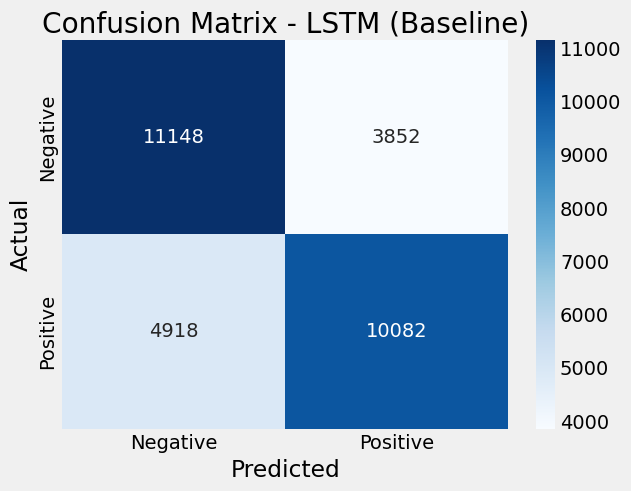

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.74      0.72     15000
           1       0.72      0.67      0.70     15000

    accuracy                           0.71     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.71      0.71      0.71     30000



In [80]:
print('Accuracy: {}'.format(accuracy_score(y_test, lstm_pred_base)))
print('Precision: {}'.format(precision_score(y_test, lstm_pred_base)))
print('Recall: {}'.format(recall_score(y_test, lstm_pred_base)))
print('F1-Score: {}'.format(f1_score(y_test, lstm_pred_base)))

lstm_cm = confusion_matrix(y_test, lstm_pred_base)

sns.heatmap(lstm_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LSTM (Baseline)')
plt.show()
print('-'*60)
print(classification_report(y_test, lstm_pred_base))

The baseline LSTM model did not perform so well; it seems to produce really high accuracy for the training dataset but did not perform as well on the testing dataset. Overfitting might be an issue here. This time, we shall create another LSTM model but employ the GloVe embedding method instead.

### LSTM with GloVe Embedding

References:
- https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

In [50]:
## LSTM using GloVe embedding

GloVe = 'drive/MyDrive/IT1244_Team13_Project/Code/glove.twitter.27B.100d.txt' # Pre-trained GloVe embedding
    
words = dict()
def add_to_dict(d, file):
    with open(file, 'r', encoding="utf-8") as f:
        for line in f.readlines():
            line = line.split(' ')
            
            try:
                d[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue
    
add_to_dict(words, GloVe) # Create dictionary words for embedding later

In [51]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

#Helper functions for preprocessing train data into appropriate training data for LSTM model

def message_to_token_list(s): # Tokenization
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

def message_to_word_vectors(message, word_dict=words): # Word Embedding 
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens: # Remove words not found in dictionary i.e 'words' dictionary generated above
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

def df_to_X_y(dff): # Seperate pandas df to X (sentences) and y (labels)
  y = dff['label'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['text']:
    message_as_vector_seq = message_to_word_vectors(message)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 100))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

def pad_X(X, desired_sequence_length=40): # Padding
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    if sequence_length_difference < 0:
        X_copy[i] = x[:desired_sequence_length]
    else:
        pad = np.zeros(shape=(sequence_length_difference, 100))
        X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)



In [52]:
og_df = deepcopy(df[['label', 'text']])
train_df = og_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)
# Split into 70:15:15 for Train:Validation:Test
train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(70000, 15000, 15000)

## Neural Network Hyperparameter Tuning

In [49]:
# # Define the hyperparameter search space

# pad = 40 # LOWER THIS VALUE IF COLAB CRASHES BECAUSE OF INSUFFICIENT RAM

# def build_model(hp):
#     nodes = hp.Int('nodes', min_value=16, max_value=256, step=8)
#     drop = hp.Float('drop', min_value=0.1, max_value=0.5, step=0.1)
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=(40, 100)))
#     model.add(tf.keras.layers.LSTM(
#         units=nodes,
#         return_sequences=True
#     ))
#     model.add(tf.keras.layers.Dropout(
#         rate=drop
#     ))
#     model.add(tf.keras.layers.LSTM(
#         units=nodes,
#         return_sequences=True
#     ))
#     model.add(tf.keras.layers.Dropout(
#         rate=drop
#     ))
#     model.add(tf.keras.layers.Dense(
#         units=nodes,
#         activation='relu'
#     ))
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#                 loss=tf.keras.losses.BinaryCrossentropy(),
#                 metrics=['accuracy'])
    
#     return model

# # Define the hyperparameter tuner
# tuner = keras_tuner.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=5,
#     factor=3,
#     directory='E:',
#     project_name='LSTM_Hyperparmeters2'
# )


# # Start the hyperparameter search
# X_train, y_train = df_to_X_y(train_df)
# X_train = pad_X(X_train, pad)
# X_val, y_val = df_to_X_y(val_df)
# X_val = pad_X(X_val, pad)
# tuner.search(X_train, y_train, batch_size = 100, validation_data=(X_val, y_val))

# # Get the best hyperparameters and retrain the model
# #best_model = tuner.get_best_models(num_models=1)[0]
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# Number of nodes : {best_hps.get('nodes')} Dropout: {best_hps.get('drop')}.
# """)

In [82]:
#LSTM Modelling

pad = 40 # LOWER THIS VALUE IF COLAB CRASHES BECAUSE OF INSUFFICIENT RAM

model = Sequential([])

model.add(tf.keras.layers.Input(shape=(pad, 100)))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3)) # Improves Generalizability of model
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 128)           117248    
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 40, 128)           131584    
                                                                 
 dense_8 (Dense)             (None, 40, 128)           16512     
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 5121      
                                                                 
Total params: 270,465
Trainable params: 270,465
Non-tr

In [ ]:
cp = ModelCheckpoint('model/', monitor='val_accuracy', save_best_only=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'Precision', 'Recall'])
# TRAINING THE MODEL COMMENT OUT IF NOT REQUIRED, Pre-trained model has already been provided by us in the IT1244 file can skip to next code block

# X_train, y_train = df_to_X_y(train_df)
# X_train = pad_X(X_train, pad)
# X_val, y_val = df_to_X_y(val_df)
# X_val = pad_X(X_val, pad)

# history = model.fit(X_train, y_train, batch_size = 35, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

In [53]:
best_model = load_model('drive/MyDrive/IT1244_Team13_Project/Code/model') # Load model into network
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           131584    
                                                                 
 dense (Dense)               (None, 40, 128)           16512     
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5121      
                                                                 
Total params: 270,465
Trainable params: 270,465
Non-trai

In [58]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test, pad)
lstm_pred = best_model.predict(x = X_test) # Make predictions
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred] # Rounding off probabilities to 0 or 1
lstm_scores = get_scores(y_test, lstm_pred)

469/469 [==============================] - 3s 5ms/step


Accuracy: 0.7956666666666666
Precision: 0.8060783493656768
Recall: 0.7754828326180258
F1-Score: 0.7904846537699091


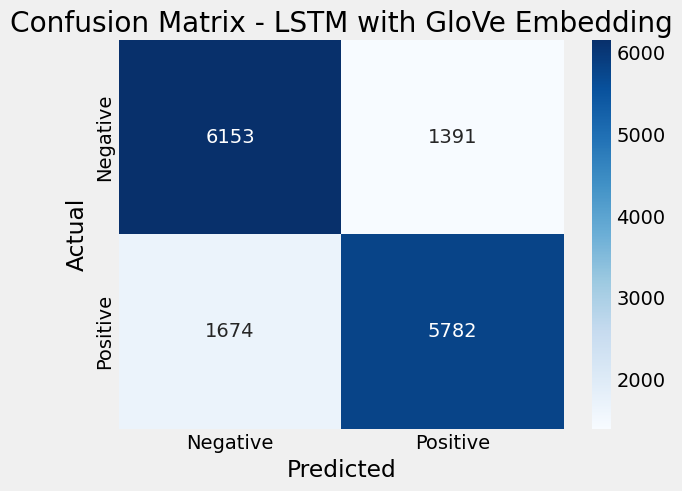

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      7544
           1       0.81      0.78      0.79      7456

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000



In [59]:
print('Accuracy: {}'.format(accuracy_score(y_test, lstm_pred)))
print('Precision: {}'.format(precision_score(y_test, lstm_pred)))
print('Recall: {}'.format(recall_score(y_test, lstm_pred)))
print('F1-Score: {}'.format(f1_score(y_test, lstm_pred)))

lstm_cm = confusion_matrix(y_test, lstm_pred)

sns.heatmap(lstm_cm, annot = True, cmap = 'Blues', fmt = 'd', 
           xticklabels = ['Negative', 'Positive'],
           yticklabels = ['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LSTM with GloVe Embedding')
plt.show()
print('-'*60)
print(classification_report(y_test, lstm_pred))

In [81]:
lstm_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
lstm_df['Model'] = ['LSTM (Baseline)', 'LSTM (with GloVe Embedding)']
lstm_df['Accuracy'] = [lstm_scores_base[0], lstm_scores[0]]
lstm_df['Precision'] = [lstm_scores_base[1], lstm_scores[1]]
lstm_df['F1-Score'] = [lstm_scores_base[2], lstm_scores[2]]
lstm_df['Recall'] = [lstm_scores_base[3], lstm_scores[3]]
lstm_df.set_index('Model', inplace = True)

display(lstm_df)

Accuracy  Precision    Recall  F1-Score
Model                                                               
LSTM (Baseline)              0.707667   0.723554  0.672133  0.696896
LSTM (with GloVe Embedding)  0.795667   0.806078  0.775483  0.790485

Here, we can see that using GloVe embedding (compared to basic tokenization) as well as changing the layers in the neural network to include more LSTM, dense and dropout layers as well as tuning with Keras caused our evaluation metrics to improve across the board, with accuracy rising by almost 10%.

### Exploring Incorrect Predictions

In [ ]:
# Create a DataFrame to store the incorrect predictions
incorrect_predictions = pd.DataFrame(columns=['index', 'y_test', 'y_predicted'])

# Iterate over the test data and predictions
for i, (y_true, y_pred) in enumerate(zip(y_test, lstm_pred)):
    # Check if the prediction is incorrect
    if y_true != y_pred:
        # Add the index of the incorrect prediction to the DataFrame
        incorrect_predictions = pd.concat([incorrect_predictions, pd.DataFrame({
            'index': [i],
            'y_test': [y_true],
            'y_predicted': [y_pred]
        })], ignore_index=True)

# Create a list to store the text of the incorrect predictions
text_list = []

# Iterate over the rows of the incorrect_predictions DataFrame
for i, row in incorrect_predictions.iterrows():
    # Get the index of the incorrect prediction
    index = row['index']
    # Get the text of the incorrect prediction from the test_df DataFrame
    text = test_df.iloc[index]['text']
    # Add the text to the list
    text_list.append(text)

# Update the incorrect_predictions DataFrame to include the text instead of the index
incorrect_predictions['text'] = text_list
incorrect_predictions = incorrect_predictions.drop(columns=['index'])

Some of the text that our models predicted wrongly could have been due to incorrect labelling of the text data in the first place. For example, "mmm i hope you get better ryan" is labeled as a negative tweet but it could also be intepreted as a positive tweet which is what the model actually predicts.

In [ ]:
incorrect_predictions.tail()

y_test y_predicted                                               text
3060      0           1  trying to decide whether to post everything or...
3061      0           1                                     play the piano
3062      0           1                     mmm i hope you get better ryan
3063      0           1                             is still awake and its
3064      1           0                its always windy where jackie lives

## Model Evaluation

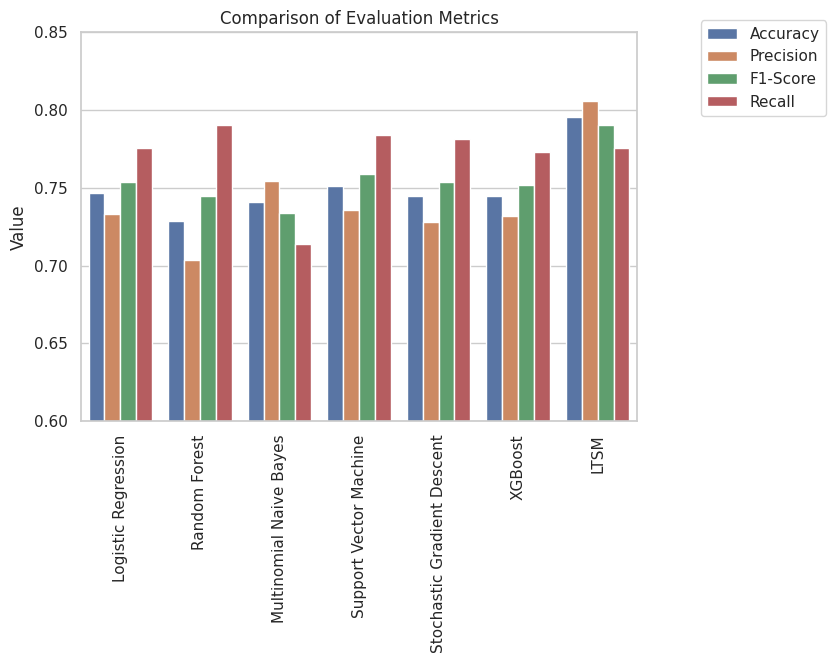

In [ ]:
scores = [logreg_scores, rf_scores, mnb_scores, svc_scores, sgdc_scores, xgb_scores, lstm_scores]
scores = pd.DataFrame(scores, columns = ['Accuracy', 'Precision', 'F1-Score', 'Recall'])
classifiers = pd.DataFrame(['Logistic Regression','Random Forest','Multinomial Naive Bayes',\
                            'Support Vector Machine', 'Stochastic Gradient Descent', \
                            'XGBoost', 'LTSM'], columns = ['classifier'])
scores = pd.concat([classifiers, scores], axis=1)
scores.set_index('classifier', inplace=True)
scores = scores.stack().to_frame('value').reset_index()
scores.rename(columns={'level_1':'score'},inplace=True)

sns.set(style='whitegrid')
sns.barplot(data = scores, x='classifier', y='value', hue='score')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Comparison of Evaluation Metrics')
plt.xlabel('')
plt.ylabel('Value')
plt.xticks(rotation = 90)
plt.ylim((0.6, 0.85))
plt.show()

For our primary means of evaluating model performance, we shall use accuracy as both classes are balanced in a 50:50 split, meaning we do not have to take into account class imbalance. In the case of class imbalance, other metrics such as F1-score or recall might be more relevant. Furthermore, the cost of incorrectly predicting classes is not high as it does not have any negative impacts, as compared to something like a binary classification for whether a client will default on credit or not whereby misclassification can yield grievous effects.

#### Summary

Using accuracy as our primary evaluation metric, our top 5 models would be (in no particular order):
- LSTM
- Stochastic Gradient Descent
- Logistic Regression
- Support Vector Machine
- XGBoost


